In [3]:
import jax
jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
#import keql_tools
#reload(keql_tools)
#from keql_tools import *
from Kernels import *
from EquationModel import *
from jax.scipy.linalg import solve
from EquationModel import *
from GP_sampler import *
from plotting import *
from evaluation_metrics import *

import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize

from LM_Solve import adaptive_refine_solution

/home/josorior/miniconda3/envs/myjaxenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils

In [9]:
## Utils
# Build interior and boundary grids
def build_xy_grid(x_range,y_range,num_grid_x,num_grid_y):
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    full_y_grid = jnp.linspace(y_range[0],y_range[1],num_grid_y)

    x_interior = full_x_grid[1:-1]
    y_interior = full_y_grid[1:-1]
    
    x_boundary = full_x_grid[jnp.array([0,-1])]
    y_boundary = full_y_grid[jnp.array([0,-1])]

    #Get interior points
    x,y = jnp.meshgrid(x_interior,y_interior)
    xy_interior = jnp.vstack([x.flatten(),y.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    x,y = jnp.meshgrid(x_interior,y_boundary)
    xy_boundary_1 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_interior)
    xy_boundary_2 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_boundary)
    xy_boundary_3 = jnp.vstack([x.flatten(),y.flatten()]).T

    xy_boundary = jnp.vstack([xy_boundary_1,xy_boundary_2,xy_boundary_3])
    return xy_interior,xy_boundary

In [10]:
def get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, vmapped_rhs, seed):
    """
        Gets samples(functions) of GP. 

        Args:
            num_obs (list): List of integers of number of observed points per function.
            xy_int (jnp.array): Interior domain to get the sample.
            xy_bdy (jnp.array): Boundary domain.
            vmapped_u_true_functions (list): List of vmapped u true functions.
            vmapped_u_true_functions (list): List of vmapped f true functions.
            seed (int): Integer to fix the simulation.

        Returns:
            list: List of lists xy_obs, u_obs, f_obs.   
    """

    if len(num_obs) != len(vmapped_u_true_functions):
        raise Exception("len of list of provided observed points not same as len of list of provided functions.")
    
    num_f = len(vmapped_rhs)
    key = jax.random.PRNGKey(seed)
    seed = jax.random.randint(key=key, shape=(num_f,), minval=1, maxval=40)
    xy_obs, u_obs, f_obs =  [], [], []
    for i, num_ob in enumerate(num_obs):
        np.random.seed(seed[i])
        xy_sample_indsi = np.random.choice(list(np.arange(len(xy_int))),num_ob,replace = False)
        xy_obsi = jnp.vstack([xy_bdy,xy_int[xy_sample_indsi]])
        xy_obs.append(xy_obsi)
        u_obs.append(vmapped_u_true_functions[i](xy_obsi))
        f_obs.append(vmapped_rhs[i](xy_obsi))
    return xy_obs, u_obs, f_obs

In [11]:
# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

In [12]:
def run_exp(m, obs_pts,run):
    # Define grid to get samples from GP
    x_grid=jnp.linspace(0,1,25)
    y_grid=jnp.linspace(0,1,25)
    X,Y=jnp.meshgrid(x_grid,y_grid)
    pairs = jnp.vstack([X.ravel(), Y.ravel()]).T

    # Sample m training functions from a GP
    kernel_GP = get_gaussianRBF(0.5)
    u_true_functions = tuple(GP_sampler(num_samples = m,
                                            X = pairs, 
                                            kernel = kernel_GP,
                                            reg = 1e-12,
                                            seed = run
                                        )  
                                        )

    # Permeability field A
    def A(xy):
        x = xy[0]
        y = xy[1]
        return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

    # Compute f = Pu for any u
    def get_rhs_darcy(u):
        def Agradu(xy):
            return A(xy)*jax.grad(u)(xy)
        def Pu(xy):
            return jnp.trace(jax.jacfwd(Agradu)(xy))
        return Pu

    # Lists of m true u's and f's
    vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
    rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed

    # Define the num of ghost points for each u
    num_grid_points = 8
    # Ghost grid - Same per function
    xy_int,xy_bdy = build_xy_grid([0,1],[0,1],num_grid_points,num_grid_points)
    xy_all = jnp.vstack([xy_bdy,xy_int])

    # Number of observed points per u
    num_obs = [obs_pts]*m

    xy_obs, u_obs, f_obs = get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, rhs_functions, seed=2024)

    # Build interpolants for u's
    k_u = get_gaussianRBF(0.5)
    u_models = tuple([InducedRKHS(
        xy_all,
        feature_operators,
        k_u
        ) for i in range(m)])
    
    # Get necessary tuples
    observation_points = tuple(xy_obs)
    observation_values = tuple(u_obs)
    collocation_points = (xy_int,)*m

    rhs_values = tuple(rhs_func(xy_int) for rhs_func in rhs_functions)

    all_u_params_init = tuple([model.get_fitted_params(obs_loc,obs_val) for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

    grid_features_u_init = jnp.vstack([(model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
                len(xy_int),
                len(feature_operators),
                order = 'F'
            ) for model,model_params in zip(u_models,all_u_params_init) ])


    k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init,c=1)
    k_P_x_part = get_gaussianRBF(0.4)
    def k_P(x,y):
        return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

    class P_model():

        kernel_function = jit(
            get_kernel_block_ops(k_P,[eval_k],[eval_k])
        )

        num_params = len(grid_features_u_init)

        @jit
        def predict(input_data,params):
            K = P_model.kernel_function(input_data,input_data)
            return K@params
        
        def get_P_eval(input_data,params):
            def predict(prediction_points):
                K = P_model.kernel_function(prediction_points,input_data)
                return K@params
            return predict
        
    collocation_points = tuple([xy_int]*m)
    
    EqnModel  = OperatorPDEModel(
        P_model,
        u_models,
        observation_points,
        observation_values,
        collocation_points,
        feature_operators,
        rhs_values,
        datafit_weight = 5.,
    )

    params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(xy_int))])

    params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
        params_init.copy(),
        EqnModel,
        beta = 1e-8,
        max_iter = 501,
        init_alpha=3,
        line_search_increase_ratio=2.
    )

    p_adjusted,refinement_losses,reg_sequence = adaptive_refine_solution(params,EqnModel,1e-1,500)

    u_sols = EqnModel.get_u_params(p_adjusted)
    P_sol = EqnModel.get_P_params(p_adjusted)

    # Testing grid
    num_fine_grid = 50
    x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

    # Estimated P from 1.5 step method
    model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)    
    S_train = model_grid_features_all
    P_func = P_model.get_P_eval(S_train,P_sol)

    # Estimated P from 2 step method
    init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
    S_train_2 = init_P_features 
    K = P_model.kernel_function(S_train_2,S_train_2)
    P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.stacked_collocation_rhs)
    P_func2 = P_model.get_P_eval(S_train_2,P_params_naive)

    # P[\phi(w)](fine_grid)
    def evaluate_hatP(P_func, w, fine_grid, feature_operators):

        # Build S_test
        w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine_int) for operator in feature_operators]).T
        model_fine_features = jnp.hstack([fine_grid, w_features])
        S_test = model_fine_features


        #P_preds_model_features = P_model.kernel_function(S_test,S_train)@P_sol 
        P_preds = P_func(S_test)
        return P_preds
    
    # In sample errors

    # Get list of approximated functions ^U = [^u_1, ^u_2, ^u_3]
    true = [f(xy_fine_int) for f in rhs_functions]

    u_approx_funcs = [u_models[ind].get_eval_function(u_sols[ind]) 
                    for ind in range(m)]
    pred1_5 = [
        evaluate_hatP(
        P_func,
        u, xy_fine_int,feature_operators) for u in u_approx_funcs
    ]

    twostep_u_approx_funcs = [u_models[ind].get_eval_function(all_u_params_init[ind]) 
                    for ind in range(m)]
    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in twostep_u_approx_funcs
    ]
    in_sample_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)])) # RMSE
    in_sample_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))
    

    # Out of sample
    M = 50
    kernel_GP = get_gaussianRBF(0.2)
    # Sample M test functions from GP(0,K)
    w_test_functions = GP_sampler(num_samples = M,
                    X = pairs, 
                    kernel = kernel_GP,
                    reg = 1e-12,
                    seed = run
                    )
    vmapped_w_test_functions = tuple([jax.vmap(w) for w in w_test_functions]) # vmap'ed
    w_rhs_functions = tuple([jax.vmap(get_rhs_darcy(w)) for w in w_test_functions]) #vmap'ed

    # mean 
    true = [f_w(xy_fine_int) for f_w in w_rhs_functions]
    #pred = [evaluate_hatP(w, xy_fine_int, u_sols, P_sol,feature_operators) for w in w_test_functions]
    pred1_5 = [
        evaluate_hatP(
        lambda x:P_model.kernel_function(x,S_train)@P_sol,
        w, xy_fine_int,feature_operators) for w in w_test_functions
    ]

    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in w_test_functions
    ]

    out_sample_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
    out_sample_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))

    return in_sample_1_5, in_sample_2, out_sample_1_5, out_sample_2

## Structure to store the errors

We create a dictionary called `err` to store errors (nrmse) where we denote the keys as follows:

>  `1_5_mthd`: This is the main algorithm.

>  `2_obs`: This means that its parent method was trained using the observed functions at 2 points.

>  `i_dis`: List of list which contains the errors for P at the training functions.

>  `o_dis`: List of list which contains the errors for P at the testing functions.

In [13]:
err = {
    '1_5_mthd': {
        '2_obs': {'i_dis': [],'o_dis': []},
        '4_obs': {'i_dis': [],'o_dis': []},
        '8_obs': {'i_dis': [],'o_dis': []}
                  },
    '2_mthd':   {
        '2_obs': {'i_dis': [],'o_dis': []},
        '4_obs': {'i_dis': [],'o_dis': []},
        '8_obs': {'i_dis': [],'o_dis': []}
                }
}

In [ ]:
NUM_FUN_LIST = [2,4,8,16]
NUM_RUNS = 10
OBS_PTS_LIST = [2,4,8]

for obs_pt in OBS_PTS_LIST:
    for m in NUM_FUN_LIST:
        i_dis_1_5 = []
        i_dis_2 = []
        o_dis_1_5 = []
        o_dis_2 = []
        for run in range(NUM_RUNS):
            # Run
            res = run_exp(m, obs_pt, run)
            # Append
            i_dis_1_5.append(res[0])
            i_dis_2.append(res[1])
            o_dis_1_5.append(res[2])
            o_dis_2.append(res[3])
        # Append each list    
        err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'].append(i_dis_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['i_dis'].append(i_dis_2)
        err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'].append(o_dis_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['o_dis'].append(o_dis_2)    
    # Save after 
    jnp.save('err',err)

## Plots

In [4]:
err = jnp.load('err.npy', allow_pickle=True).item()

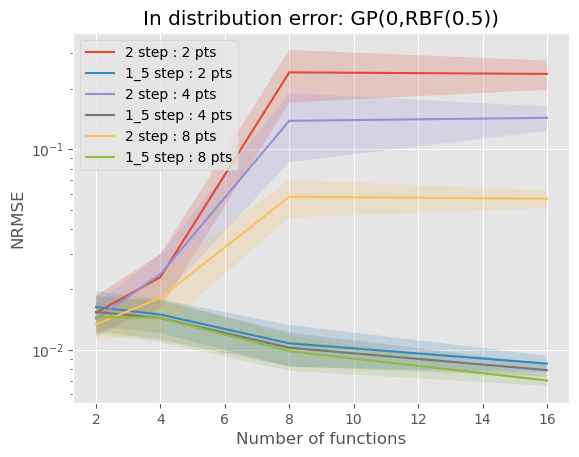

In [13]:
# In distribution plot
plt.title('In distribution error: GP(0,RBF(0.5))')
ms = [2,4,8,16]
OBS_PTS_LIST = [2,4,8]
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_i_dis_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    sd_i_dis_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # 2 method
    mean_i_dis_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    sd_i_dis_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # Plot 2 method
    plt.plot(ms, mean_i_dis_2, label = f'2 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_dis_2 - sd_i_dis_2, mean_i_dis_2 + sd_i_dis_2, alpha=.2)
    plt.yscale('log')
    # Plot 1_5 method
    plt.plot(ms, mean_i_dis_1_5, label = f'1_5 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_dis_1_5 - sd_i_dis_1_5, mean_i_dis_1_5 + sd_i_dis_1_5, alpha=.2)
    plt.yscale('log')
plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
plt.legend()
plt.show()

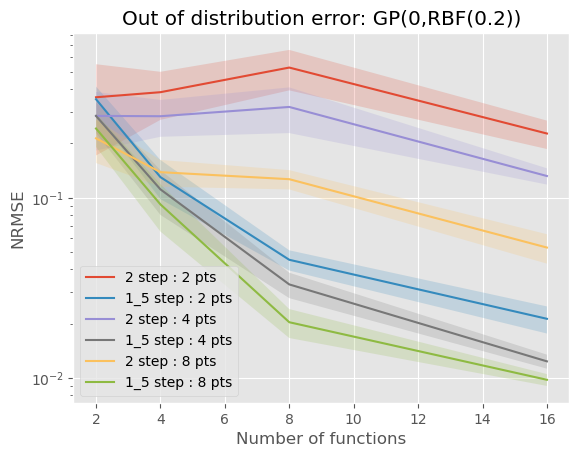

In [14]:
# Out of distribution
plt.title('Out of distribution error: GP(0,RBF(0.2))')
ms = [2,4,8,16]
OBS_PTS_LIST = [2,4,8]
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_o_dis_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    sd_o_dis_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # 2 method
    mean_o_dis_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    sd_o_dis_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # Plot 2 method
    plt.plot(ms, mean_o_dis_2, label = f'2 step : {obs_pt} pts')
    plt.fill_between(ms, mean_o_dis_2 - sd_o_dis_2, mean_o_dis_2 + sd_o_dis_2, alpha=.2)
    plt.yscale('log')
    # Plot 1_5 method
    plt.plot(ms, mean_o_dis_1_5, label = f'1_5 step : {obs_pt} pts')
    plt.fill_between(ms, mean_o_dis_1_5 - sd_o_dis_1_5, mean_o_dis_1_5 + sd_o_dis_1_5, alpha=.2)
    plt.yscale('log')
plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
plt.legend()
plt.show()